In [1]:
# Automated Feature Selection Pipeline

import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Custom transformer for correlation filtering
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.to_keep = None

    def fit(self, X, y=None):
        df = pd.DataFrame(X)
        corr_matrix = df.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_keep = [column for column in upper.columns if not any(upper[column] > self.threshold)]
        return self

    def transform(self, X):
        return pd.DataFrame(X).iloc[:, self.to_keep].values

# Load data
X, y = load_breast_cancer(return_X_y=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define pipeline
pipeline = Pipeline([
    ("var_thresh", VarianceThreshold(threshold=0.01)),
    ("corr_filter", CorrelationFilter(threshold=0.85)),
    ("select_kbest", SelectKBest(score_func=mutual_info_classif, k=10)),
    ("classifier", RandomForestClassifier(random_state=42))
])

# Fit and evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=5. All the features will be returned.
  warnings.warn(


Accuracy: 0.956140350877193


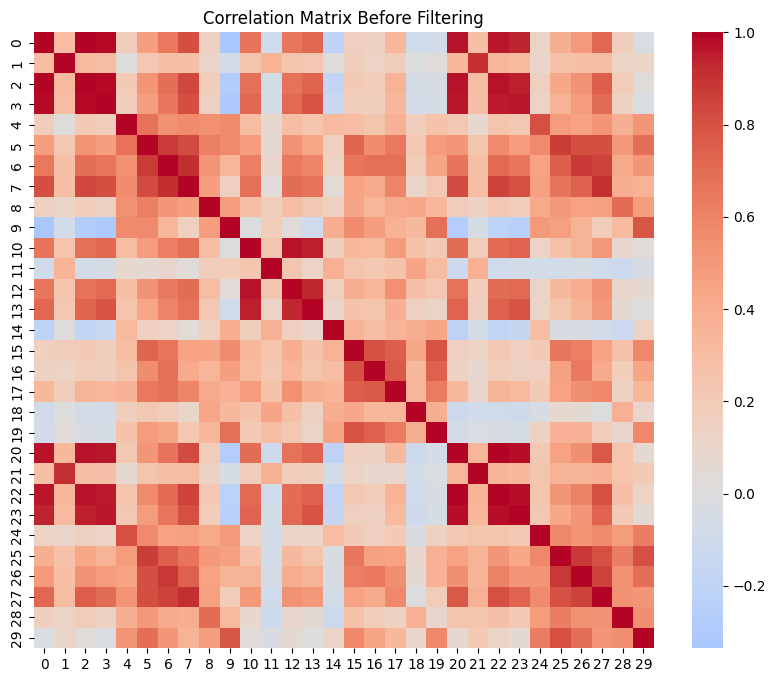

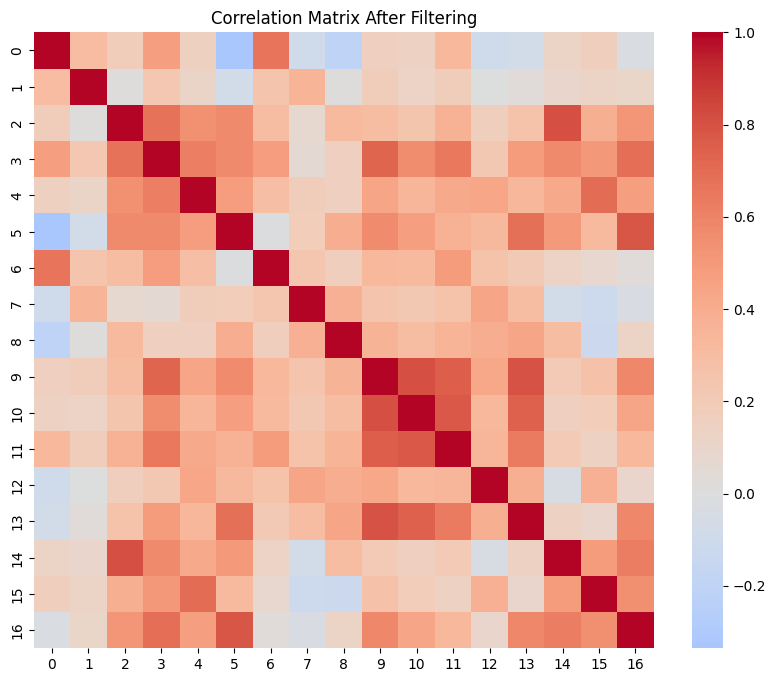

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Before filtering
corr_matrix_before = pd.DataFrame(X_train).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_before, cmap='coolwarm', center=0)
plt.title("Correlation Matrix Before Filtering")
plt.show()

# After filtering
X_corr_filtered = CorrelationFilter(threshold=0.85).fit_transform(X_train)
corr_matrix_after = pd.DataFrame(X_corr_filtered).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_after, cmap='coolwarm', center=0)
plt.title("Correlation Matrix After Filtering")
plt.show()


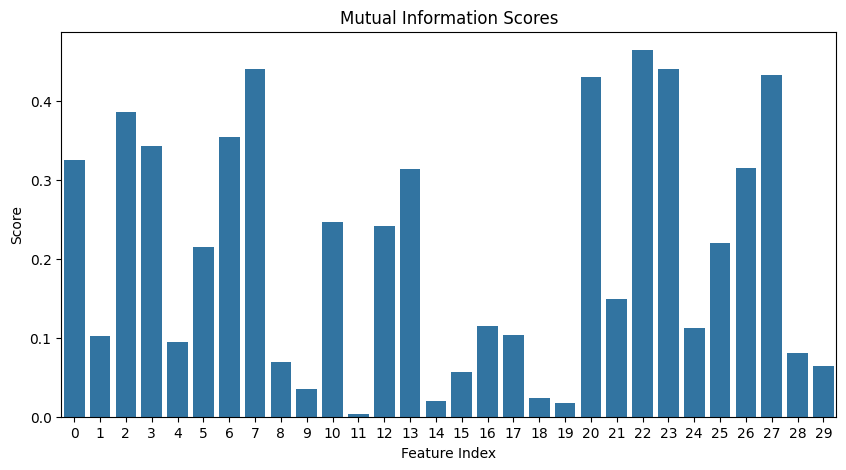

In [3]:
mi = mutual_info_classif(X_train, y_train)
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(len(mi)), y=mi)
plt.title("Mutual Information Scores")
plt.xlabel("Feature Index")
plt.ylabel("Score")
plt.show()


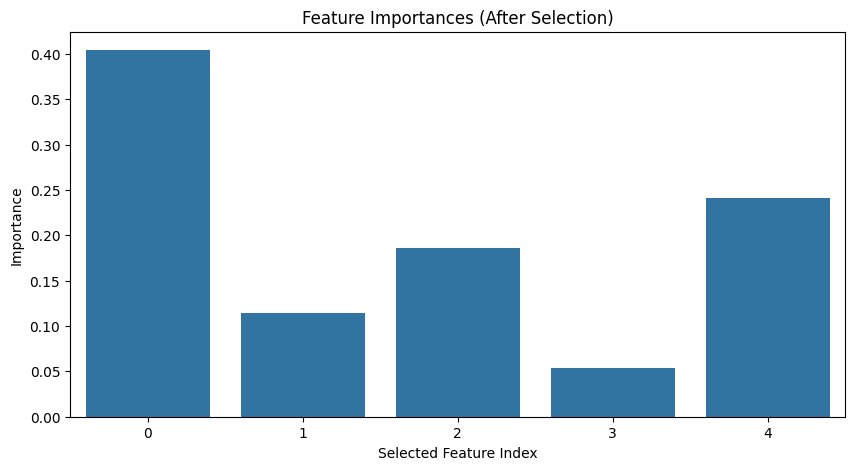

In [4]:
importances = pipeline.named_steps["classifier"].feature_importances_
features_selected = pipeline.named_steps["select_kbest"].get_support(indices=True)

plt.figure(figsize=(10, 5))
sns.barplot(x=features_selected, y=importances)
plt.title("Feature Importances (After Selection)")
plt.xlabel("Selected Feature Index")
plt.ylabel("Importance")
plt.show()




---

### Foundational Resources on Feature Selection

* **Guyon & Elisseeff (2003)** – *An Introduction to Variable and Feature Selection*
  A highly cited overview covering motivations, definitions, filter vs wrapper methods, and their practical implications in high-dimensional domains like text and genomics ([arXiv][1], [jmlr.org][2]).

* **Pudjihartono et al. (2022)** – *A Review of Feature Selection Methods for Machine Learning*
  A contemporary review focusing on filter, wrapper, and embedded methods—including mutual information and redundancy—highlighting their use cases, strengths, and limitations ([PMC][3]).

---

### Correlation-Based Feature Selection

* **Hall (1999)** – *Correlation-based Feature Selection for Machine Learning*
  Introduces correlation-based subset evaluation, which aligns with your custom `CorrelationFilter` approach to reduce redundancy while preserving predictive relevance ([lri.fr][4]).

* **mRMR: Minimum Redundancy Maximum Relevance**
  A well-known feature selection framework that balances feature relevance (via mutual information) against redundancy among features ([Wikipedia][5]).

---

### Mutual Information–Based Selection

* **Verleysen et al. (2009)** – *Advances in Feature Selection with Mutual Information*
  Addresses limitations of MI estimation in high-dimensional spaces and proposes enhancements like resampling and redundancy-aware selection ([arXiv][1]).

* **Beraha et al. (2019)** – *Feature Selection via Mutual Information: New Theoretical Insights*
  Offers theoretical bounds for MI-based selection and introduces principled greedy stopping conditions to ensure bounded prediction error ([arXiv][6]).

* **Cheng et al. (2022)** – MI combined with Variance Inflation Factor (MI-VIF)
  Proposes a hybrid approach that incorporates MI and statistical redundancy (VIF), reflecting your pipeline’s design: using filter + correlation-based pruning ([ScienceDirect][7]).

---

### Comprehensive Comparative Studies

* **Cheng (2024)** – *A Comprehensive Study of Feature Selection Techniques in Machine Learning Models*
  Compares filter, wrapper, and embedded approaches, and underscores the computational and interpretability advantages of hybrid pipelines like yours ([ResearchGate][8]).

---

### Summary Table: Key Academic References

| Pipeline Component               | Supporting Reference                                               |
| -------------------------------- | ------------------------------------------------------------------ |
| General Feature Selection Theory | Guyon & Elisseeff (2003); Pudjihartono et al. (2022)               |
| Correlation-Based Pruning        | Hall (1999); mRMR framework (Peng et al.)                          |
| Mutual Information Filtering     | Verleysen et al. (2009); Beraha et al. (2019); Cheng MI-VIF (2022) |
| Hybrid / Comparative Approaches  | Cheng (2024)                                                       |

---

[1]: https://arxiv.org/abs/0909.0635?utm_source=chatgpt.com "Advances in Feature Selection with Mutual Information"
[2]: https://www.jmlr.org/papers/volume3/guyon03a/guyon03a.pdf?utm_source=chatgpt.com "An Introduction to Variable and Feature Selection"
[3]: https://pmc.ncbi.nlm.nih.gov/articles/PMC9580915/?utm_source=chatgpt.com "A Review of Feature Selection Methods for Machine ..."
[4]: https://www.lri.fr/~pierres/donn%EF%BF%BDes/save/these/articles/lpr-queue/hall99correlationbased.pdf?utm_source=chatgpt.com "Correlation-based Feature Selection for Machine Learning"
[5]: https://en.wikipedia.org/wiki/Feature_selection?utm_source=chatgpt.com "Feature selection"
[6]: https://arxiv.org/abs/1907.07384?utm_source=chatgpt.com "Feature Selection via Mutual Information: New Theoretical Insights"
[7]: https://www.sciencedirect.com/science/article/abs/pii/S1386142521012294?utm_source=chatgpt.com "A variable selection method based on mutual information ..."
[8]: https://www.researchgate.net/publication/386160114_A_Comprehensive_Study_of_Feature_Selection_Techniques_in_Machine_Learning_Models?utm_source=chatgpt.com "A Comprehensive Study of Feature Selection Techniques ..."
